In [2]:
FOLDER = "./"

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import gc
import skimage.io

Global Variables (constant value)

In [32]:
#Data path
train_dir = './data/train_keras'

In [33]:
train_size = len(os.listdir(train_dir))

print(train_size)

20580


In [35]:
os.listdir(train_dir)

['n02085620_10074.jpg',
 'n02085620_10131.jpg',
 'n02085620_10621.jpg',
 'n02085620_1073.jpg',
 'n02085620_10976.jpg',
 'n02085620_11140.jpg',
 'n02085620_11238.jpg',
 'n02085620_11258.jpg',
 'n02085620_11337.jpg',
 'n02085620_11477.jpg',
 'n02085620_1152.jpg',
 'n02085620_11696.jpg',
 'n02085620_11818.jpg',
 'n02085620_11948.jpg',
 'n02085620_1205.jpg',
 'n02085620_12101.jpg',
 'n02085620_12334.jpg',
 'n02085620_1235.jpg',
 'n02085620_1271.jpg',
 'n02085620_12718.jpg',
 'n02085620_1298.jpg',
 'n02085620_13151.jpg',
 'n02085620_1321.jpg',
 'n02085620_13383.jpg',
 'n02085620_1346.jpg',
 'n02085620_13964.jpg',
 'n02085620_14252.jpg',
 'n02085620_14413.jpg',
 'n02085620_14516.jpg',
 'n02085620_1455.jpg',
 'n02085620_1492.jpg',
 'n02085620_1502.jpg',
 'n02085620_1558.jpg',
 'n02085620_1569.jpg',
 'n02085620_1617.jpg',
 'n02085620_1620.jpg',
 'n02085620_1765.jpg',
 'n02085620_1816.jpg',
 'n02085620_1862.jpg',
 'n02085620_1916.jpg',
 'n02085620_199.jpg',
 'n02085620_2053.jpg',
 'n02085620_21

In [34]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

In [10]:
#Count/Print train and test samples.
data_size = get_num_files(train_dir)
print('Data samples size: ', data_size)

Data samples size:  20580


In [11]:
train_labels = pd.read_csv('./data/train_labels.csv')

In [12]:
target, dog_breeds = pd.factorize(train_labels['breed'], sort = True)
train_labels['target'] = target
print(dog_breeds)

Index(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier',
       'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel',
       'Border_collie',
       ...
       'schipperke', 'silky_terrier', 'soft', 'standard_poodle',
       'standard_schnauzer', 'toy_poodle', 'toy_terrier', 'vizsla', 'whippet',
       'wire'],
      dtype='object', length=120)


In [13]:
display(train_labels.head())

,id,breed,target
0,n02107683_4807,Bernese_mountain_dog,7
1,n02090721_936,Irish_wolfhound,36
2,n02116738_1849,African_hunting_dog,1
3,n02107142_814,Doberman,19
4,n02093991_3604,Irish_terrier,34


In [14]:
train_labels['breed'].value_counts()

Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
Bernese_mountain_dog    218
                       ... 
malinois                150
affenpinscher           150
kuvasz                  150
Pekinese                149
redbone                 148
Name: breed, Length: 120, dtype: int64

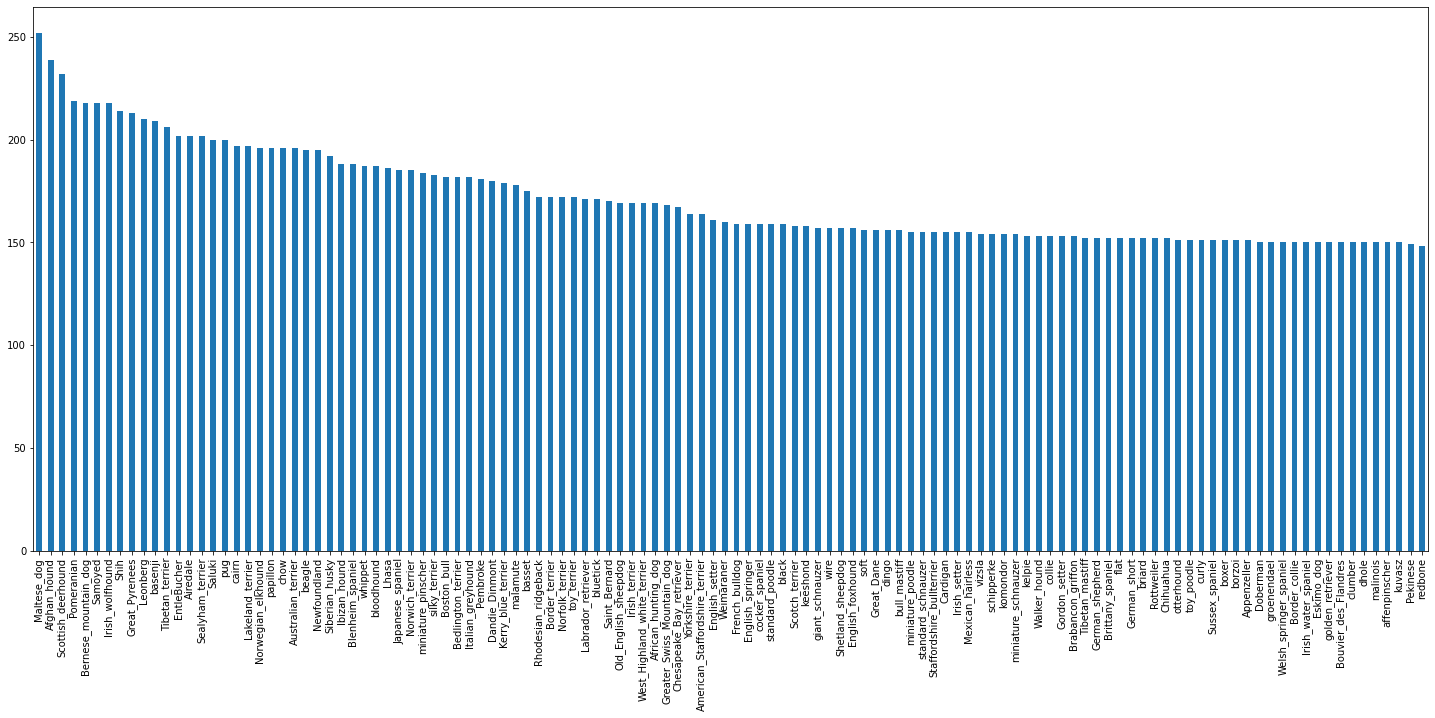

In [15]:
plt.figure(figsize=(25, 10))
train_labels['breed'].value_counts().plot(kind='bar')
plt.show()

In [16]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(train_labels['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:3]

120


['Afghan_hound', 'African_hunting_dog', 'Airedale']

In [17]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [18]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):
    '''
    1- Read image samples from certain directory.
    2- Risize it, then stack them into one big numpy array.
    3- Read sample's label form the labels dataframe.
    4- One hot encode labels array.
    5- Shuffle Data and label arrays.
    '''
    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and lables.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    #One hot encoder
    y = to_categorical(y)
    #shuffle    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y

In [19]:
img_size = (224, 224, 3)
try:
  X = np.load(FOLDER + "224X_save.npy")
  y = np.load(FOLDER + "224y_save.npy")
  print(len(X), len(y))
except: 
  #img_size chosen to be 331 to suit the used architectures.
  X, y = images_to_array(train_dir, train_labels, img_size)
  np.save(FOLDER + "224X_save", X)
  np.save(FOLDER + "224y_save", y)

20580 20580


In [19]:
def get_features(model_name, data_preprocessor, input_size, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    print(feature_extractor)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=128, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [20]:
# Extract features using InceptionV3 as extractor.
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

161/161 [==============================] - 803s 5s/step
Feature maps shape:  (20580, 2048)


In [21]:
# Extract features using Xception as extractor.
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

161/161 [==============================] - 1361s 8s/step
Feature maps shape:  (20580, 2048)


In [22]:
# Extract features using NASNetLarge as extractor.
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

161/161 [==============================] - 4228s 26s/step
Feature maps shape:  (20580, 4032)


In [23]:
# Extract features using InceptionResNetV2 as extractor.
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

161/161 [==============================] - 2053s 13s/step
Feature maps shape:  (20580, 1536)


In [24]:
#It's a good habit to free up some RAM memory.
#X variable won't be needed anymore, so let's get rid of it.
del X

In [25]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (20580, 9664)


In [26]:
final_features.shape[1:]

(9664,)

In [27]:
final_features

array([[3.4027866e-01, 1.0158153e-01, 2.2238995e-01, ..., 4.0919982e-02,
        7.2603464e-02, 9.2766456e-02],
       [2.7393711e-01, 5.4492933e-01, 4.1350342e-02, ..., 1.5411060e-01,
        3.9026490e-01, 8.2073286e-03],
       [4.9532313e-02, 2.4044918e-01, 9.0225093e-02, ..., 2.8439958e-02,
        0.0000000e+00, 3.2437825e-01],
       ...,
       [6.6388674e-02, 1.7463437e-01, 1.8231302e-01, ..., 6.2364444e-02,
        2.2248771e-02, 4.4273954e-02],
       [4.3352193e-01, 5.6232698e-02, 4.4775823e-01, ..., 1.0601473e+00,
        7.1490481e-03, 6.7630634e-02],
       [1.1209728e-01, 8.4560230e-02, 8.2679026e-02, ..., 6.7324872e-04,
        3.0214417e-01, 7.1658292e-03]], dtype=float32)

In [28]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [29]:
#Prepare DNN model
dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 9664)              0         
                                                                 
 dense (Dense)               (None, 120)               1159800   
                                                                 
Total params: 1,159,800
Trainable params: 1,159,800
Non-trainable params: 0
_________________________________________________________________


In [31]:
#Train simple DNN on extracted features.
h = dnn.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=my_callback)

Epoch 1/60
145/145 [==============================] - 2s 9ms/step - loss: 0.5527 - accuracy: 0.8771 - val_loss: 0.1862 - val_accuracy: 0.9397
Epoch 2/60
145/145 [==============================] - 1s 9ms/step - loss: 0.1653 - accuracy: 0.9476 - val_loss: 0.1980 - val_accuracy: 0.9388
Epoch 3/60
145/145 [==============================] - 1s 8ms/step - loss: 0.1291 - accuracy: 0.9582 - val_loss: 0.2006 - val_accuracy: 0.9417
Epoch 4/60
145/145 [==============================] - 1s 9ms/step - loss: 0.1109 - accuracy: 0.9623 - val_loss: 0.2380 - val_accuracy: 0.9363
Epoch 5/60
145/145 [==============================] - 1s 9ms/step - loss: 0.0989 - accuracy: 0.9666 - val_loss: 0.2044 - val_accuracy: 0.9412
Epoch 6/60
145/145 [==============================] - 1s 9ms/step - loss: 0.0878 - accuracy: 0.9683 - val_loss: 0.2159 - val_accuracy: 0.9383
Epoch 7/60
145/145 [==============================] - 1s 9ms/step - loss: 0.0782 - accuracy: 0.9714 - val_loss: 0.2197 - val_accuracy: 0.9388
Epoch 

In [32]:
class DogBreedClassification():
  def __init__(self, model_list, processor_list, input_size):
    self.model_list = model_list
    self.processor_list = processor_list
    self.input_size = input_size
    print("image_size: ", image_size)


  def get_features(self, model_name, data_preprocessor, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    #Prepare pipeline.
    input_layer = Input(self.input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    print(feature_extractor)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=128, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

  def extract_features(self, data):
    model_and_processor = zip(self.model_list, self.processor_list)
    feature_list = []
    for model, preprocessor in model_and_processor:
      feature_list.append(self.get_features(model, preprocessor, data))
    final_features = np.concatenate(feature_list, axis=-1)
    return final_features

  def _make_dnn_model(self):
    dnn = keras.models.Sequential([
      InputLayer(final_features.shape[1:]),
      Dropout(0.7),
      Dense(n_classes, activation='softmax')
      ])
    dnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    self.dnn = dnn

In [29]:
x = np.load(FOLDER + "224X_save.npy")

In [31]:
x.shape

(20580, 224, 224, 3)

In [27]:
for idx in range(len(X)):
    plt.imsave('./data/train_ae/doggy/'+str(idx)+'.png', X[idx])